# 라이브러리 호출

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchsummary import summary

import torchvision
import torchvision.transforms as transforms  # 데이터 전처리를 위해 사용하는 라이브러리
import torchvision.datasets as datasets
import torchvision.models as models

import numpy as np
import matplotlib.pyplot as plt
import copy
from collections import namedtuple # 튜플의 성질을 갖고 있는 자료형이지만 인덱스뿐만 아니라 키 값으로 데이터에 접근할 수 있음.
import os
import random
import time

import cv2
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 이미지 데이터 전처리

In [3]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train' : transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),   # 이미지를 수직으로 랜덤하게 뒤집기
                transforms.RandomRotation(20),     # -20도에서 20도 사이로 이미지를 랜덤하게 회전
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # 밝기, 대비, 채도를 랜덤하게 변경
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val' : transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase):
        return self.data_transform[phase](img)

# 변수에 대한 값 정의

In [4]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [5]:
from google.colab import files
from google.colab import drive

drive.mount('/content/drive')

# 이미지가 저장된 폴더 경로를 지정합니다. 해당 경로는 Google Drive 내에 있는 폴더여야 합니다.
base_folder_path = '/content/drive/MyDrive/파이썬 기반 딥러닝학습/Data/train'

non_demented_folder = 'NonDemented'
verymild_demented_folder = 'VeryMildDemented'
mild_demented_folder = 'MildDemented'
moderate_demented_folder = 'ModerateDemented'

non_demented_image_filepaths = [os.path.join(base_folder_path, non_demented_folder, f) for f in os.listdir(os.path.join(base_folder_path, non_demented_folder))]
verymild_demented_image_filepaths = [os.path.join(base_folder_path, verymild_demented_folder, f) for f in os.listdir(os.path.join(base_folder_path, verymild_demented_folder))]
mild_demented_image_filepaths = [os.path.join(base_folder_path, mild_demented_folder, f) for f in os.listdir(os.path.join(base_folder_path, mild_demented_folder))]
moderate_demented_image_filepaths = [os.path.join(base_folder_path, moderate_demented_folder, f) for f in os.listdir(os.path.join(base_folder_path, moderate_demented_folder))]

# 모든 이미지 파일 경로를 하나의 리스트로 합칩니다.
images_filepaths = [*non_demented_image_filepaths, *verymild_demented_image_filepaths, *mild_demented_image_filepaths, *moderate_demented_image_filepaths]

# 이미지 파일을 읽어올 때 유효한 이미지 파일인지 확인합니다.
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
len(correct_images_filepaths) # train 데이터셋 파일 갯수.

5121

In [7]:
# random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:4097] # 0.8% -> train
val_images_filepaths = correct_images_filepaths[4097:] # 0.2% -> validation
print(len(train_images_filepaths), len(val_images_filepaths))

4097 1024


# 이미지 데이터 확인

In [8]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

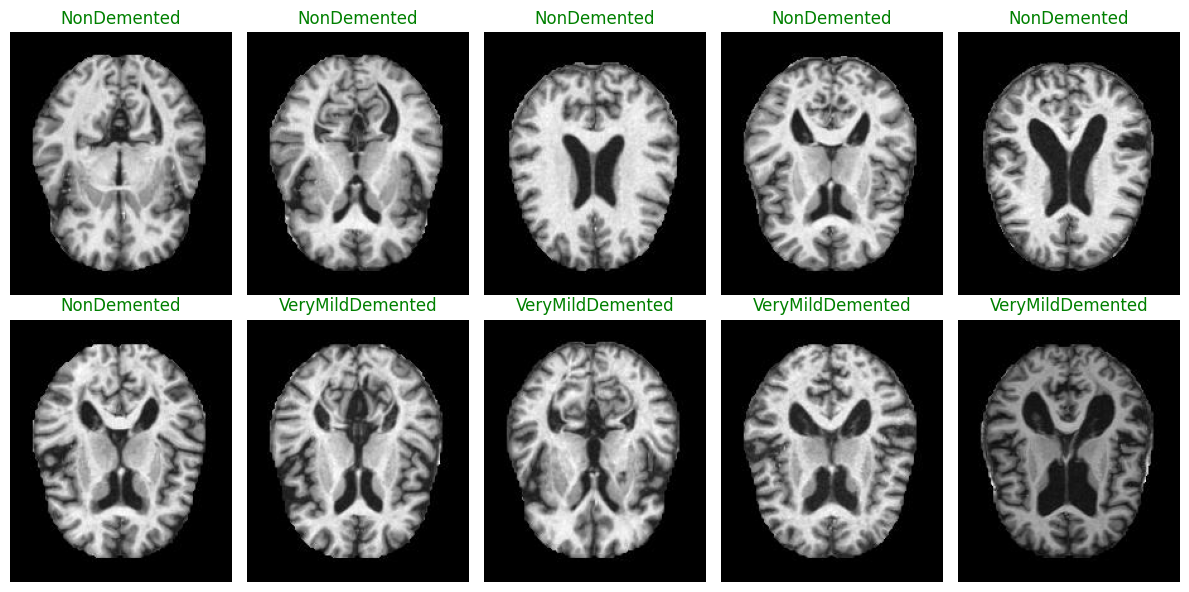

In [9]:
%matplotlib inline

display_image_grid(val_images_filepaths[:10])

# 이미지에 대한 레이블 구분

In [10]:
class alzheimerDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):

        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]

        img = Image.open(img_path).convert('RGB')
        img_transformed = self.transform(img, self.phase)

        label = img_path.split('/')[-1].split('.')[0]
        if label.startswith('nonDem'):
            label = 0
        elif label.startswith('verymildDem'):
            label = 1
        elif label.startswith('mildDem'):
            label = 2
        elif label.startswith('moderateDem'):
            label = 3
        return img_transformed, label

# 이미지 데이터셋 정의

In [11]:
train_dataset = alzheimerDataset(train_images_filepaths,
                                 transform=ImageTransform(size, mean, std),
                                 phase='train')
val_dataset = alzheimerDataset(val_images_filepaths,
                              transform=ImageTransform(size, mean, std),
                              phase='val')

index = 0 # index 0의 이미지 크기와 레이블에 대한 출력
print(train_dataset.__getitem__(index)[0].size()) # 이미지는 컬러(채널 3) 상태에서 224 * 224 크기를 갖고 있음.
print(train_dataset.__getitem__(index)[1]) # 0을 의미하기에 Non Demented

torch.Size([3, 224, 224])
0


# 데이터셋의 데이터를 메모리로 불러오기

In [12]:
train_iterator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_iterator = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_iterator, 'val': valid_iterator}

batch_iterator = iter(train_iterator)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([0, 0, 2, 0, 1, 1, 0, 1, 0, 1, 2, 2, 2, 1, 1, 0, 1, 2, 2, 1, 2, 0, 0, 1,
        1, 0, 0, 0, 1, 1, 2, 2])


# Efficient Net

## 모델을 구축하기 전에 Swish 활성화 함수를 정의합니다.

In [13]:
# Swish activation function
class Swish(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)

## SE Block

In [14]:
# SE Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, r=4):
        super().__init__()

        self.squeeze = nn.AdaptiveAvgPool2d((1,1))
        self.excitation = nn.Sequential(
            nn.Linear(in_channels, in_channels * r),
            Swish(),
            nn.Linear(in_channels * r, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.squeeze(x)
        x = x.view(x.size(0), -1)
        x = self.excitation(x)
        x = x.view(x.size(0), x.size(1), 1, 1)
        return x

## MBConv

In [15]:
class MBConv(nn.Module):
    expand = 6
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, se_scale=4, p=0.5):
        super().__init__()
        # first MBConv is not using stochastic depth
        self.p = torch.tensor(p).float() if (in_channels == out_channels) else torch.tensor(1).float()

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * MBConv.expand, 1, stride=stride, padding=0, bias=False),
            nn.BatchNorm2d(in_channels * MBConv.expand, momentum=0.99, eps=1e-3),
            Swish(),
            nn.Conv2d(in_channels * MBConv.expand, in_channels * MBConv.expand, kernel_size=kernel_size,
                      stride=1, padding=kernel_size//2, bias=False, groups=in_channels*MBConv.expand),
            nn.BatchNorm2d(in_channels * MBConv.expand, momentum=0.99, eps=1e-3),
            Swish()
        )

        self.se = SEBlock(in_channels * MBConv.expand, se_scale)

        self.project = nn.Sequential(
            nn.Conv2d(in_channels*MBConv.expand, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        )

        self.shortcut = (stride == 1) and (in_channels == out_channels)

    def forward(self, x):
        # stochastic depth
        if self.training:
            if not torch.bernoulli(self.p):
                return x

        x_shortcut = x
        x_residual = self.residual(x)
        x_se = self.se(x_residual)

        x = x_se * x_residual
        x = self.project(x)

        if self.shortcut:
            x= x_shortcut + x

        return x

## SepConv

In [16]:
class SepConv(nn.Module):
    expand = 1
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, se_scale=4, p=0.5):
        super().__init__()
        # first SepConv is not using stochastic depth
        self.p = torch.tensor(p).float() if (in_channels == out_channels) else torch.tensor(1).float()

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels * SepConv.expand, in_channels * SepConv.expand, kernel_size=kernel_size,
                      stride=1, padding=kernel_size//2, bias=False, groups=in_channels*SepConv.expand),
            nn.BatchNorm2d(in_channels * SepConv.expand, momentum=0.99, eps=1e-3),
            Swish()
        )

        self.se = SEBlock(in_channels * SepConv.expand, se_scale)

        self.project = nn.Sequential(
            nn.Conv2d(in_channels*SepConv.expand, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        )

        self.shortcut = (stride == 1) and (in_channels == out_channels)

    def forward(self, x):
        # stochastic depth
        if self.training:
            if not torch.bernoulli(self.p):
                return x

        x_shortcut = x
        x_residual = self.residual(x)
        x_se = self.se(x_residual)

        x = x_se * x_residual
        x = self.project(x)

        if self.shortcut:
            x= x_shortcut + x

        return x

## EfficientNet

In [17]:
class EfficientNet(nn.Module):
    def __init__(self, num_classes=4, width_coef=1., depth_coef=1., scale=1., dropout=0.2, se_scale=4, stochastic_depth=False, p=0.5):
        super().__init__()
        channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]
        repeats = [1, 2, 2, 3, 3, 4, 1]
        strides = [1, 2, 2, 2, 1, 2, 1]
        kernel_size = [3, 3, 5, 3, 5, 5, 3]
        depth = depth_coef
        width = width_coef

        channels = [int(x*width) for x in channels]
        repeats = [int(x*depth) for x in repeats]

        # stochastic depth
        if stochastic_depth:
            self.p = p
            self.step = (1 - 0.5) / (sum(repeats) - 1)
        else:
            self.p = 1
            self.step = 0


        # efficient net
        self.upsample = nn.Upsample(scale_factor=scale, mode='bilinear', align_corners=False)

        self.stage1 = nn.Sequential(
            nn.Conv2d(3, channels[0],3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(channels[0], momentum=0.99, eps=1e-3)
        )

        self.stage2 = self._make_Block(SepConv, repeats[0], channels[0], channels[1], kernel_size[0], strides[0], se_scale)

        self.stage3 = self._make_Block(MBConv, repeats[1], channels[1], channels[2], kernel_size[1], strides[1], se_scale)

        self.stage4 = self._make_Block(MBConv, repeats[2], channels[2], channels[3], kernel_size[2], strides[2], se_scale)

        self.stage5 = self._make_Block(MBConv, repeats[3], channels[3], channels[4], kernel_size[3], strides[3], se_scale)

        self.stage6 = self._make_Block(MBConv, repeats[4], channels[4], channels[5], kernel_size[4], strides[4], se_scale)

        self.stage7 = self._make_Block(MBConv, repeats[5], channels[5], channels[6], kernel_size[5], strides[5], se_scale)

        self.stage8 = self._make_Block(MBConv, repeats[6], channels[6], channels[7], kernel_size[6], strides[6], se_scale)

        self.stage9 = nn.Sequential(
            nn.Conv2d(channels[7], channels[8], 1, stride=1, bias=False),
            nn.BatchNorm2d(channels[8], momentum=0.99, eps=1e-3),
            Swish()
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(p=dropout)
        self.linear = nn.Linear(channels[8], num_classes)

    def forward(self, x):
        x = self.upsample(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x)
        x = self.stage7(x)
        x = self.stage8(x)
        x = self.stage9(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.linear(x)
        return x


    def _make_Block(self, block, repeats, in_channels, out_channels, kernel_size, stride, se_scale):
        strides = [stride] + [1] * (repeats - 1)
        layers = []
        for stride in strides:
            layers.append(block(in_channels, out_channels, kernel_size, stride, se_scale, self.p))
            in_channels = out_channels
            self.p -= self.step

        return nn.Sequential(*layers)


def efficientnet_b0(num_classes=4):
    return EfficientNet(num_classes=num_classes, width_coef=1.0, depth_coef=1.0, scale=1.0,dropout=0.2, se_scale=4)

def efficientnet_b1(num_classes=4):
    return EfficientNet(num_classes=num_classes, width_coef=1.0, depth_coef=1.1, scale=240/224, dropout=0.2, se_scale=4)

def efficientnet_b2(num_classes=4):
    return EfficientNet(num_classes=num_classes, width_coef=1.1, depth_coef=1.2, scale=260/224., dropout=0.3, se_scale=4)

def efficientnet_b3(num_classes=4):
    return EfficientNet(num_classes=num_classes, width_coef=1.2, depth_coef=1.4, scale=300/224, dropout=0.3, se_scale=4)

def efficientnet_b4(num_classes=4):
    return EfficientNet(num_classes=num_classes, width_coef=1.4, depth_coef=1.8, scale=380/224, dropout=0.4, se_scale=4)

def efficientnet_b5(num_classes=4):
    return EfficientNet(num_classes=num_classes, width_coef=1.6, depth_coef=2.2, scale=456/224, dropout=0.4, se_scale=4)

def efficientnet_b6(num_classes=4):
    return EfficientNet(num_classes=num_classes, width_coef=1.8, depth_coef=2.6, scale=528/224, dropout=0.5, se_scale=4)

def efficientnet_b7(num_classes=4):
    return EfficientNet(num_classes=num_classes, width_coef=2.0, depth_coef=3.1, scale=600/224, dropout=0.5, se_scale=4)

# ResNet

## 기본 블록 정의

In [18]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False) # 3 x 3 합성곱층
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False) # 3 x 3 합성곱층
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        if downsample: # 다운 샘플이 적용되는 부분.
            conv = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                            stride=stride, bias=False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)

        else:
            downsample = None

        self.downsample = downsample

    def forward(self, x):
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x

## 병목 블록 정의

In [19]:
class Bottlenect(nn.Module):
    expansion = 4 # ResNet에서 병목 블록을 정의하기 위한 하이퍼 파라미터.

    def __init__(self, in_channels, out_channels, stride=1, downsample=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                              stride=1, bias=False) # 1 x 1 합성곱층
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False) # 3 x 3 합성곱층
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, self.expansion*out_channels,
                              kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        self.relu = nn.ReLU(inplace=True)

        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion*out_channels, kernel_size=1,
                            stride=stride, bias=False)
            bn = nn.BatchNorm2d(self.expansion*out_channels)
            downsample = nn.Sequential(conv, bn)

        else:
            downsample = None
        self.downsample = downsample

    def forward(self, x):
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)
        return x

## ResNet 모델 네트워크

In [20]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim, zero_init_residual=False):
        super().__init__()

        block, n_blocks, channels = config
        self.in_channels = channels[0]
        assert len(n_blocks) == len(channels) == 4

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2,
                              padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride=2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride=2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.in_channels, output_dim)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottlenect):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def get_resnet_layer(self, block, n_blocks, channels, stride=1):
        layers = []
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False

        layers.append(block(self.in_channels, channels, stride, downsample))
        for i in range(1, n_blocks):
            layers.append(block(block.expansion*channels, channels))

        self.in_channels = block.expansion * channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        return x, h

## ResNetConfig 정의

In [21]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

### 기본 블록을 사용하여 ResNetConfig 정의

In [22]:
resnet18_config = ResNetConfig(block=BasicBlock,
                              n_blocks=[2, 2, 2, 2],
                              channels=[64, 128, 256, 512])

resnet34_config = ResNetConfig(block=BasicBlock,
                              n_blocks=[3, 4, 6, 3],
                              channels=[64, 128, 256, 512])

### 병목 블록을 사용하여 ResNetConfig 정의

In [23]:
resnet50_config = ResNetConfig(block=Bottlenect,
                              n_blocks=[3, 4, 6, 3],
                              channels=[64, 128, 256, 512])

resnet101_config = ResNetConfig(block=Bottlenect,
                              n_blocks=[3, 4, 23, 3],
                              channels=[64, 128, 256, 512])

resnet152_config = ResNetConfig(block=Bottlenect,
                              n_blocks=[3, 8, 36, 3],
                              channels=[64, 128, 256, 512])

## ResNet152 Config를 사용한 ResNet 모델 사용

In [24]:
OUTPUT_DIM = 4
model = ResNet(resnet152_config, OUTPUT_DIM)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottlenect(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Ensemble Model

In [25]:
# class EnsembleModel(nn.Module):
#     def __init__(self, efficientnet, resnet):
#         super(EnsembleModel, self).__init__()
#         self.efficientnet = efficientnet
#         self.resnet = resnet
#         self.fc = nn.Linear(OUTPUT_DIM * 2, OUTPUT_DIM)  # OUTPUT_DIM은 최종 클래스 수입니다.

#     def forward(self, x):
#         # EfficientNet 및 ResNet의 각각의 forward 호출
#         efficientnet_output = self.efficientnet(x)
#         resnet_output = self.resnet(x)

#         # 만약 출력이 튜플이라면, 첫 번째 요소만 사용합니다.
#         if isinstance(efficientnet_output, tuple):
#             efficientnet_output = efficientnet_output[0]

#         if isinstance(resnet_output, tuple):
#             resnet_output = resnet_output[0]

#         # EfficientNet 및 ResNet의 출력을 결합
#         combined_output = torch.cat([efficientnet_output, resnet_output], dim=1)

#         # 최종 선형 레이어를 통해 최종 예측 생성
#         final_output = self.fc(combined_output)

#         return final_output


# # EfficientNet과 ResNet 모델 생성
# efficientnet_model = efficientnet_b0(num_classes=OUTPUT_DIM)
# resnet_model = ResNet(resnet152_config, OUTPUT_DIM)

# # 앙상블 모델 생성
# ensemble_model = EnsembleModel(efficientnet_model, resnet_model)

# # 모델 출력 확인
# print(ensemble_model)

EnsembleModel(
  (efficientnet): EfficientNet(
    (upsample): Upsample(scale_factor=1.0, mode='bilinear')
    (stage1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    )
    (stage2): Sequential(
      (0): SepConv(
        (residual): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
          (2): Swish(
            (sigmoid): Sigmoid()
          )
        )
        (se): SEBlock(
          (squeeze): AdaptiveAvgPool2d(output_size=(1, 1))
          (excitation): Sequential(
            (0): Linear(in_features=32, out_features=128, bias=True)
            (1): Swish(
              (sigmoid): Sigmoid()
            )
            (2): Linear(in_features=128, out_features=32, bias=Tru

In [42]:
class EnsembleModel(nn.Module):
    def __init__(self, efficientnet, resnet, output_dim):
        super(EnsembleModel, self).__init__()
        self.efficientnet = efficientnet
        self.resnet = resnet
        self.fc = nn.Linear(output_dim * 2, output_dim)  # output_dim은 최종 클래스 수입니다.
        self.softmax = nn.Softmax(dim=1)  # Softmax 활성화 함수 추가

    def forward(self, x):
        # EfficientNet 및 ResNet의 각각의 forward 호출
        efficientnet_output = self.efficientnet(x)
        resnet_output = self.resnet(x)

        # 만약 출력이 튜플이라면, 첫 번째 요소만 사용합니다.
        if isinstance(efficientnet_output, tuple):
            efficientnet_output = efficientnet_output[0]

        if isinstance(resnet_output, tuple):
            resnet_output = resnet_output[0]

        # EfficientNet 및 ResNet의 출력을 결합
        combined_output = torch.cat([efficientnet_output, resnet_output], dim=1)

        # 최종 선형 레이어를 통해 최종 예측 생성
        final_output = self.fc(combined_output)

        # Softmax 활성화 함수를 통해 확률 분포로 변환
        final_output = self.softmax(final_output)

        return final_output

# EfficientNet과 ResNet 모델 생성
efficientnet_model = efficientnet_b0(num_classes=OUTPUT_DIM)
resnet_model = ResNet(resnet152_config, OUTPUT_DIM)

# 앙상블 모델 생성
ensemble_model = EnsembleModel(efficientnet_model, resnet_model, OUTPUT_DIM)

# 모델 출력 확인
print(ensemble_model)

EnsembleModel(
  (efficientnet): EfficientNet(
    (upsample): Upsample(scale_factor=1.0, mode='bilinear')
    (stage1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    )
    (stage2): Sequential(
      (0): SepConv(
        (residual): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
          (2): Swish(
            (sigmoid): Sigmoid()
          )
        )
        (se): SEBlock(
          (squeeze): AdaptiveAvgPool2d(output_size=(1, 1))
          (excitation): Sequential(
            (0): Linear(in_features=32, out_features=128, bias=True)
            (1): Swish(
              (sigmoid): Sigmoid()
            )
            (2): Linear(in_features=128, out_features=32, bias=Tru

# 옵티마이저와 손실 함수 정의

In [33]:
optimizer = optim.Adam(ensemble_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

ensemble_model = ensemble_model.to(device)
criterion = criterion.to(device)

# 모델 학습 정확도 측정 함수 정의

In [34]:
def calculate_topk_accuracy(y_pred, y, k=2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, dim=1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim=True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size

    return acc_1, acc_k

# 모델 학습 함수 정의

In [35]:
import torch.nn.functional as F

def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.train()

    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)

        # Check the shape of y_pred
        if isinstance(y_pred, list):
            y_pred = y_pred[0]

        # Ensure the target has the correct shape
        y = y.unsqueeze(1)  # Add an extra dimension
        y = y.repeat(1, y_pred.shape[1])  # Repeat to match the number of classes

        # Convert y to class indices
        y_indices = torch.argmax(y, dim=1)

        loss = criterion(y_pred, y_indices)

        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y_indices)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_5

# 모델 평가 함수 정의

In [36]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.eval()

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            # Check the shape of y_pred
            if isinstance(y_pred, list):
                y_pred = y_pred[0]

            # Ensure the target has the correct shape
            y = y.unsqueeze(1)  # Add an extra dimension
            y = y.repeat(1, y_pred.shape[1])  # Repeat to match the number of classes

            # Convert y to class indices
            y_indices = torch.argmax(y, dim=1)

            loss = criterion(y_pred, y_indices)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y_indices)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_5


# 모델 학습 시간 측정 함수 정의

In [37]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time/60)
    elapsed_secs = int(elapsed_time - (elapsed_mins*60))

    return elapsed_mins, elapsed_secs

# 모델 학습

In [40]:
best_valid_loss = float('inf')
EPOCHS = 10

train_accuracy = []
valid_accuracy = []

for epoch in range(EPOCHS):
    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train(ensemble_model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(ensemble_model, valid_iterator, criterion, device)

    # Append train and valid accuracy to the lists
    train_accuracy.append(train_acc_1)
    valid_accuracy.append(valid_acc_1)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/EfficientNet&ResNet_Ensemble-model.pt')


    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
         f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
         f'Valid Acc @5: {valid_acc_5*100:6.2f}%')


Epoch: 01 | Epoch Time: 10m 50s
	Train Loss: 1.646 | Train Acc @1:   0.34% | Train Acc @5:   1.07%
	Valid Loss: 1.999 | Valid Acc @1:   0.00% | Valid Acc @5:   0.00%
Epoch: 02 | Epoch Time: 10m 47s
	Train Loss: 1.594 | Train Acc @1:   1.31% | Train Acc @5:   3.27%
	Valid Loss: 4.437 | Valid Acc @1:   0.00% | Valid Acc @5:   0.00%
Epoch: 03 | Epoch Time: 10m 47s
	Train Loss: 1.544 | Train Acc @1:   2.54% | Train Acc @5:   5.74%
	Valid Loss: 1.563 | Valid Acc @1:   0.00% | Valid Acc @5:   0.00%


KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

# Plotting train and valid accuracy
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(valid_accuracy, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()